* 测试迁移学习 baseline
* https://github.com/DavexPro/fashion-tag/blob/master/transfer_learning.ipynb 进行复盘
* 在 baseline 的基础上进行 data_augmentation

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from tqdm import tqdm

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform

plt.ion()   # interactive mode

In [2]:
from torch.optim import lr_scheduler

## 导入数据

* label 文件一共有 79572 行
* 各种维度混合在一起
* 我们的目的是切分开各种维度, 进行训练和模拟
* 那么首先取出个标签的图片进行聚类

In [3]:
df_train = pd.read_csv('label.csv',header=None)
df_train.columns = ['image_id', 'class', 'label']
df_train.head()

,image_id,class,label
0,Images/collar_design_labels/4d8a38b29930a403e5...,collar_design_labels,nnynn
1,Images/collar_design_labels/bd0981f231180d2b00...,collar_design_labels,nynnn
2,Images/collar_design_labels/26937e1724feadfe39...,collar_design_labels,ynnnn
3,Images/collar_design_labels/cf4140ec542887270f...,collar_design_labels,nynnn
4,Images/collar_design_labels/50644b2b9de045f2d1...,collar_design_labels,nynnn


In [4]:
classes = ['collar_design_labels', 'neckline_design_labels', 'skirt_length_labels',
          'sleeve_length_labels', 'neck_design_labels', 'coat_length_labels', 'lapel_design_labels',
          'pant_length_labels']

## 加载数据

In [5]:
cur_class = classes[4]
df_load = df_train[(df_train['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

neck_design_labels: 5692


,image_id,class,label
0,Images/neck_design_labels/999a5bf5b42ab13667e0...,neck_design_labels,nynnn
1,Images/neck_design_labels/bc34bbee837d4eecdad1...,neck_design_labels,nnnyn
2,Images/neck_design_labels/08268c6d91790f2ca9ca...,neck_design_labels,nnynn
3,Images/neck_design_labels/605596277342df421156...,neck_design_labels,nnnyn
4,Images/neck_design_labels/d0ab90becdc5217aa9f7...,neck_design_labels,nnynn


In [6]:
Split_ration=0.9
Split_point=int(Split_ration*len(df_load))
train_load=df_load[:Split_point]
val_load = df_load[Split_point:]

In [7]:
#torch.Size([3, 224, 224])
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),#数据增强
        transforms.RandomHorizontalFlip(),#数据增强
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),#数据增强
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
class FashionLandmarksDataset(Dataset): #自定义预处理图片
    """Face Landmarks dataset."""

    def __init__(self, df_load, root_dir,img_class,transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        #self.landmarks_frame = pd.read_csv(csv_file,header=None)
        #self.df_load = self.landmarks_frame[(self.landmarks_frame.ix[:,1] == img_class)].copy()
        self.df_load =df_load
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df_load)

    def __getitem__(self, idx):
        #n = len(self.df_load)
        n_class = len(self.df_load.ix[:,2].as_matrix()[0])
        #label = np.zeros(n_class).astype(int)
        label = np.zeros(n_class)

        path=self.df_load.iloc[idx,0]
        img_name = os.path.join(self.root_dir,path)
        image = io.imread(img_name)
        #tmp_label = df_load.ix[:,2]
        #y[i][tmp_label.find('y')] = 1
        label[df_load.ix[idx, 2].find('y')]=1
        #landmarks = df_load.ix[idx, 2].as_matrix().astype('float')
        #landmarks = landmarks.reshape(-1, 2)
        #image = np.transpose(image,(2,0,1))
        #label=torch.from_numpy(label)
        
        if self.transform:
            image = self.transform(image)

        return image,label

In [9]:
train_fashion_dataset = FashionLandmarksDataset(df_load=train_load,
                                    root_dir='data/base/',
                                   img_class='neck_design_labels',
                                   transform=data_transforms['train']
                                   )

val_fashion_dataset = FashionLandmarksDataset(df_load=val_load,
                                    root_dir='data/base/',
                                   img_class='neck_design_labels',
                                   transform=data_transforms['val']
                                   )

In [10]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #显示多条结果

In [11]:
len(train_fashion_dataset)
len(val_fashion_dataset)

5122

570

In [12]:
image1,label1=train_fashion_dataset[1]

In [13]:
image1.shape

torch.Size([3, 224, 224])

In [14]:
label1

array([ 0.,  0.,  0.,  1.,  0.])

In [15]:
train_loader = Data.DataLoader(dataset=train_fashion_dataset, batch_size=4, shuffle=True,num_workers=2,) #批次数据
val_loader = Data.DataLoader(dataset=val_fashion_dataset, batch_size=4, shuffle=True,num_workers=2,) 

In [16]:
data_loader_dict={'train':train_loader,'val':val_loader}

In [17]:
dataloaders = {x: data_loader_dict[x]
              for x in ['train', 'val']}

In [18]:
dataset_sizes = {x: len(data_loader_dict[x]) for x in ['train', 'val']}

In [19]:
use_gpu = torch.cuda.is_available()

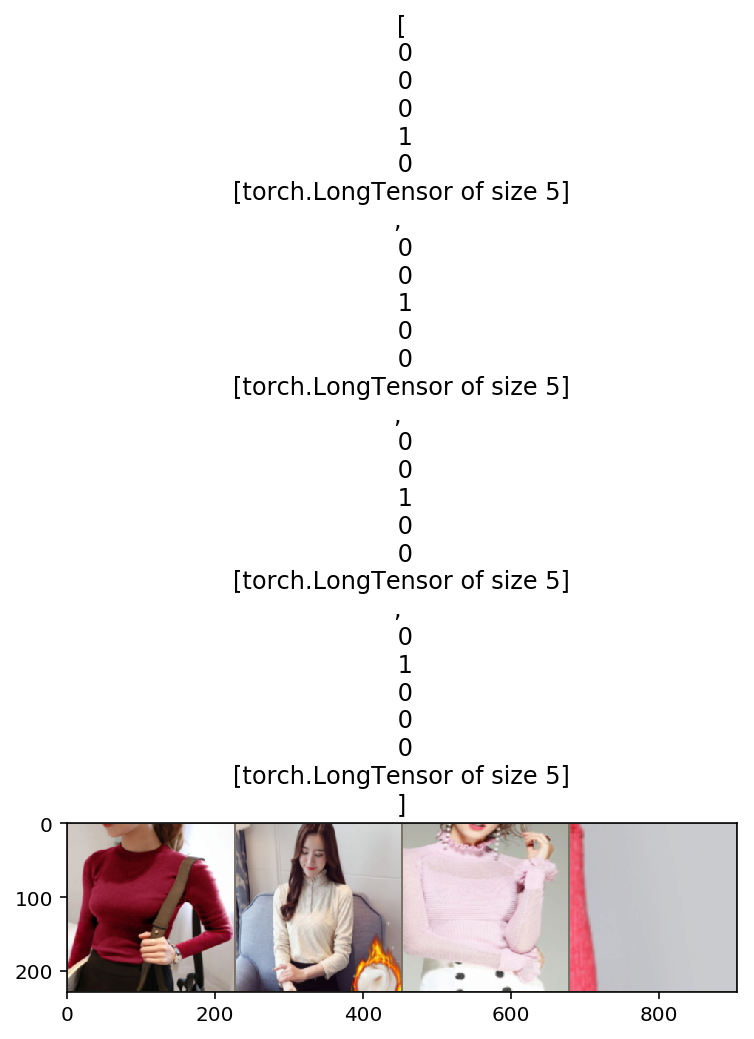

In [20]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out,title=[x for x in classes])

In [32]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                #loss = criterion(outputs, labels)
                #loss = criterion(torch.max(outputs, 1)[1], torch.max(labels, 1)[1])
                #output_type=torch.LongTensor(torch.max(outputs, 1)[1])
                #label_type=torch.LongTensor(torch.max(labels, 1)[1])
                
                label_type=Variable(torch.FloatTensor(labels)).view(1, -1)
                output_type=Variable(torch.FloatTensor(outputs)).view(1, -1)
                loss = criterion(output_type, label_type)
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [33]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.

In [34]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

#criterion = nn.MultiLabelMarginLoss()
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [35]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


TypeError: torch.FloatTensor constructor received an invalid combination of arguments - got (Variable), but expected one of:
 * no arguments
 * (int ...)
      didn't match because some of the arguments have invalid types: ([31;1mVariable[0m)
 * (torch.FloatTensor viewed_tensor)
      didn't match because some of the arguments have invalid types: ([31;1mVariable[0m)
 * (torch.Size size)
      didn't match because some of the arguments have invalid types: ([31;1mVariable[0m)
 * (torch.FloatStorage data)
      didn't match because some of the arguments have invalid types: ([31;1mVariable[0m)
 * (Sequence data)
      didn't match because some of the arguments have invalid types: ([31;1mVariable[0m)


In [ ]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.





In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## 提取特征